## Cycling Potential
### How to calculate a trip cycling potential 

This notebook aims to define parameters to calculate a trip cycling potential, considering the current characteristics of São Paulo bike trips.

It is necessary to identify all attributes, calculate the attribute specific value and to develop a method to aggregate all attributes

In [1]:
# importing data and auxiliar functions

import saopaulo.sp_grid as gr
import bikescience.distributions as dist
from bikescience.slope import plot_slope, plot_slopes, split_route

import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time

zone_shp = gpd.read_file('../data/sao-paulo/od/shapes/Zonas_2017_region.shp')
zone_shp.crs = {'init': 'epsg:31983'}  
zone_shp.to_crs(epsg='4326', inplace=True)

od_routes_sp = gpd.read_file('../data/sao-paulo/od/routes/bike_routes_in_sp.shp')
od_routes_sp.crs = {'init': 'epsg:4326'}
od_routes_sp['length'] = od_routes_sp['geometry'].length * 100000
the_grid = gr.create(n=10, west_offset=-0.15, east_offset=0.23, north_offset=0.19, south_offset=-0.46)

total_trips = sum(od_routes_sp['FE_VIA'])
eps = 1e-5

# return a list [value_10, value_20, ..., value_100] 
# where value_x is the value whose x% of the data is less than it  
def stats (data, value, weights = 'FE_VIA'):
    level = sum(data[weights])/10
    stats = []
    data = data.sort_values(value)
    total = 0
    for _, i in data.iterrows():
        total += i[weights]
        if total >= (len(stats) + 1) * level - eps:
            stats.append(i[value])
    return stats

od_routes_FE_VIA = []
for i, r in od_routes_sp.iterrows():
    for w in range(round(r['FE_VIA'])):
        od_routes_FE_VIA.append(r)
        
od_routes_FE_VIA = pd.DataFrame(data = od_routes_FE_VIA, columns = od_routes_sp.columns)

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
display(od_routes_FE_VIA)

,id,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,ID_DOM,F_DOM,FE_DOM,DOM,CD_ENTRE,...,PAG_VIAG,TP_ESAUTO,VL_EST,PE_BICI,VIA_BICI,TP_ESTBICI,ID_ORDEM,distance,geometry,length
0,449,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,0,0,0.0,1,2,8,450,2.316243,"LINESTRING Z (-46.629884 -23.548626 739.16, -4...",2145.299295
0,449,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,0,0,0.0,1,2,8,450,2.316243,"LINESTRING Z (-46.629884 -23.548626 739.16, -4...",2145.299295
0,449,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,0,0,0.0,1,2,8,450,2.316243,"LINESTRING Z (-46.629884 -23.548626 739.16, -4...",2145.299295
0,449,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,0,0,0.0,1,2,8,450,2.316243,"LINESTRING Z (-46.629884 -23.548626 739.16, -4...",2145.299295
0,449,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,0,0,0.0,1,2,8,450,2.316243,"LINESTRING Z (-46.629884 -23.548626 739.16, -4...",2145.299295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,0,0.0,2,2,3,177357,17.007105,"LINESTRING Z (-46.643442 -23.545037 769.46, -4...",16232.282688
981,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,0,0.0,2,2,3,177357,17.007105,"LINESTRING Z (-46.643442 -23.545037 769.46, -4...",16232.282688
981,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,0,0.0,2,2,3,177357,17.007105,"LINESTRING Z (-46.643442 -23.545037 769.46, -4...",16232.282688
981,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,0,0.0,2,2,3,177357,17.007105,"LINESTRING Z (-46.643442 -23.545037 769.46, -4...",16232.282688


# Distance

The first attribute we consider is the trip distance.

The longer a trip is, the less cyclable it is. The distance is calculated using the routes calculated by the GraphHopper API. 

However, very short trips are hard to migrate to cycling because they are most likely made on foot.

The current Sao Paulo bike trips distance distribution is represented in the following graphs.

distance  10%:	 994
distance  20%:	 1343
distance  30%:	 1759
distance  40%:	 2310
distance  50%:	 2893
distance  60%:	 3703
distance  70%:	 4545
distance  80%:	 6613
distance  90%:	 10372
distance  100%:	 48888


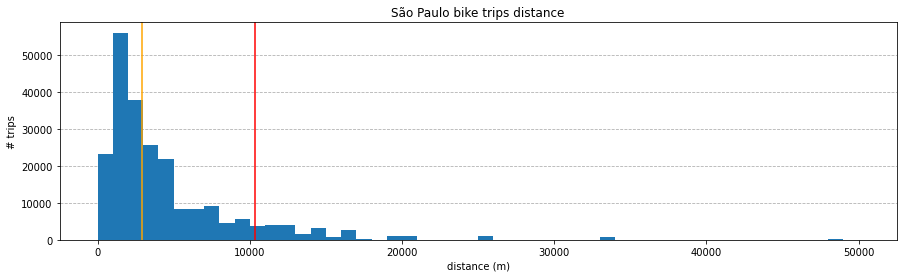

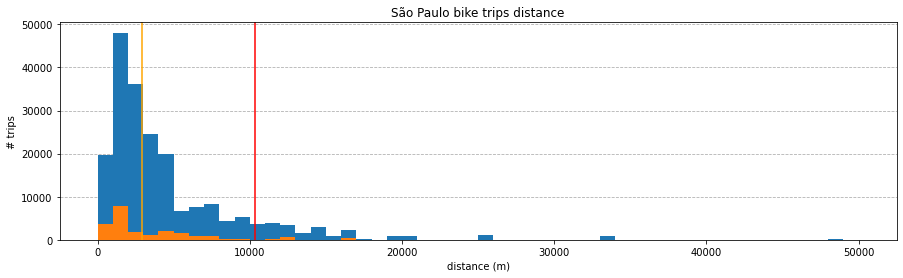

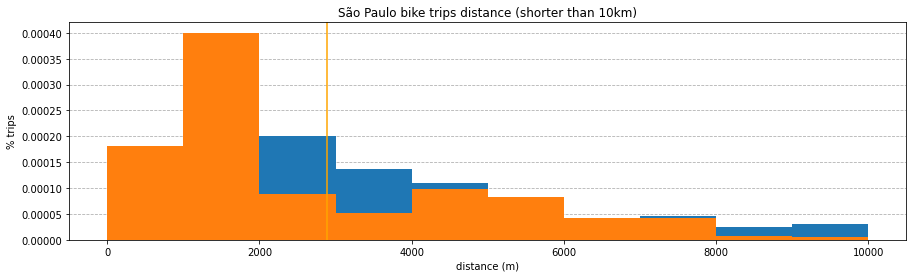

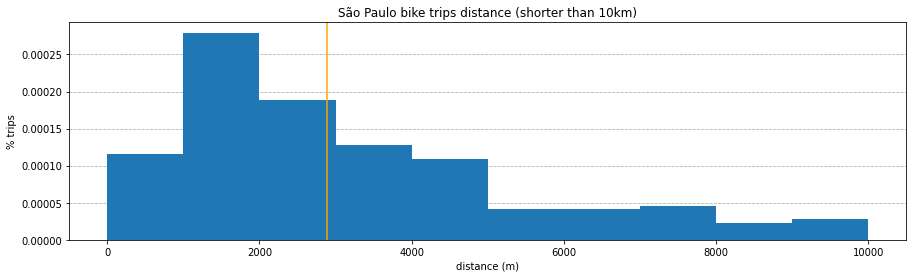

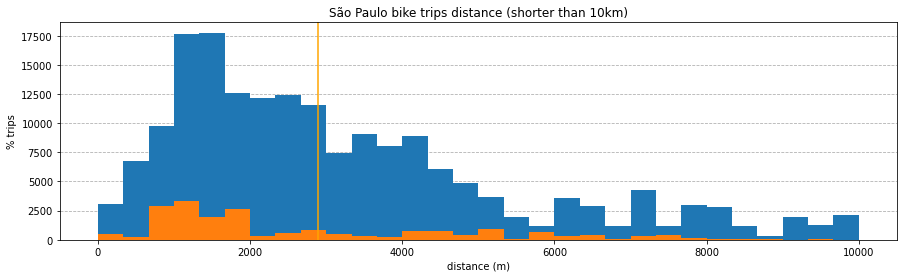

In [3]:
od_routes_sp = od_routes_sp.sort_values('length')

s = stats(od_routes_sp, 'length')
for i in range(10):
    print('distance  ' + str(i + 1) + '0%:\t', round(s[i]))
    
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=od_routes_sp['length'], 
         weights = od_routes_sp['FE_VIA'], range=(0, 50000))
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()    

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0, 50000))
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0, 50000))
plt.title('São Paulo bike trips distance')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=10,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0,10000), density=True)
plt.hist(bins=10,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0,10000), density=True)
plt.title('São Paulo bike trips distance (shorter than 10km)')
plt.xlabel('distance (m)')
plt.ylabel('% trips')
plt.axvline(x=s[4],color='orange')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=10,x=od_routes_sp['length'], 
         weights = od_routes_sp['FE_VIA'], range=(0,10000), density=True)
plt.title('São Paulo bike trips distance (shorter than 10km)')
plt.xlabel('distance (m)')
plt.ylabel('% trips')
plt.axvline(x=s[4],color='orange')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=30,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], range=(0,10000))
plt.hist(bins=30,x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], range=(0,10000))
plt.title('São Paulo bike trips distance (shorter than 10km)')
plt.xlabel('distance (m)')
plt.ylabel('% trips')
plt.axvline(x=s[4],color='orange')
plt.show()

In [5]:
od_routes_sp['length_scaled'] = od_routes_sp['length'] / max(od_routes_sp['length'])
#distrib_scaled = dist.best_fit_distribution(od_routes_sp['length_scaled'], bins = 100)

#distrib = dist.best_fit_distribution(od_routes_sp['length'], bins = 100)

#distrib_m = dist.best_fit_distribution(od_routes_FE_VIA.loc[od_routes_FE_VIA['SEXO'] == 1]['length'], bins = 30)
#distrib_f = dist.best_fit_distribution(od_routes_FE_VIA.loc[od_routes_FE_VIA['SEXO'] == 2]['length'], bins = 30)

#('fisk', (1.846058042674543, 33.070799837068655, 2961.1647009341214))
#('johnsonsu', (-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386))
#display(distrib_m, distrib_f)

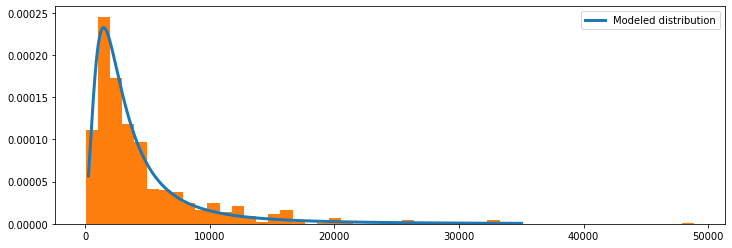

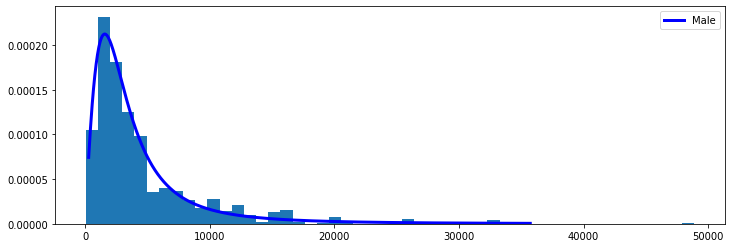

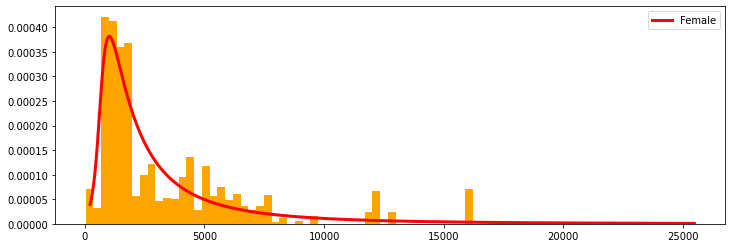

In [6]:
import scipy.stats as st

#display(distrib_weighted)
#'invweibull', (1.9570057637337088, -1328.576035175634, 3464.328480602161))

distance_pdf = dist.make_pdf(st.invweibull, (1.9570057637337088, -1328.576035175634, 3464.328480602161))
plt.figure(figsize=(12,4))
ax = distance_pdf.plot(lw=3, label='Modeled distribution', legend=True)
plt.hist(bins=50, x=od_routes_sp['length'], weights = od_routes_sp['FE_VIA'], density=True)
plt.show()

distance_pdf_m = dist.make_pdf(st.fisk, (1.846058042674543, 33.070799837068655, 2961.1647009341214))
plt.figure(figsize=(12,4))
ax = distance_pdf_m.plot(lw=3, label='Male', legend=True, color='blue')
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 1]['FE_VIA'], density=True)
plt.show()

distance_pdf_f = dist.make_pdf(st.johnsonsu, (-1.6348791801316755, 0.8220563043475115, 599.1107992085285, 401.86433888871386))
plt.figure(figsize=(12,4))
ax = distance_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.hist(bins=50, x=od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['length'], 
         weights = od_routes_sp.loc[od_routes_sp['SEXO'] == 2]['FE_VIA'], density=True,color='orange')
plt.show()

# Slope

In [7]:
# calculating statistics
stats_slope = []
for _, r in od_routes_sp.iterrows():
    s = {}
    stretchs = split_route(r['geometry'], 'line', False)
    s['fe_via'] = r['FE_VIA']
    s['length'] = r['length']
    s['max'] = max([s[1] for s in stretchs])
    s['mean'] = sum([s[1]*s[0].length for s in stretchs])/r.length * 100000
    s['mean_pos'] = sum([max(0,s[1])*s[0].length for s in stretchs])/r.length * 100000
    stretchs = split_route(r['geometry'], 20, False)
    s['std_height'] = stdev([st[0].coords[0][2] for st in stretchs])
    s['sum_elevs'] = sum (max(0, st[0].coords[0][2] - st[0].coords[1][2]) for st in stretchs)
    for i in range(-150, 150):
        s['meters_slope_' + str(i)] = 0
        s['meters_slope_max_' + str(i)] = 0
    meters_in_slope = 0
    current_slope = round(stretchs[0][1])
    for st in stretchs:
        s['meters_slope_' + str(round(st[1]))] += st[0].length * 100000
        if current_slope == round(st[1]):
            meters_in_slope += st[0].length * 100000
        else:
            s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                              s['meters_slope_max_' + str(current_slope)])
            meters_in_slope = st[0].length * 100000
            current_slope = round(st[1])
    s['meters_slope_max_' + str(current_slope)] = max(meters_in_slope, 
                                                      s['meters_slope_max_' + str(current_slope)])
        
    stats_slope.append(i[1] for i in s.items())  
    
c = ['fe_via', 'length', 'max', 'mean', 'mean_pos', 'std_height', 'sum_elevs']
for i in range(-150,150):
    c += ['meters_slope_' + str(i)] + ['meters_slope_max_' + str(i)]
df_stats = pd.DataFrame(data = stats_slope, columns = c)

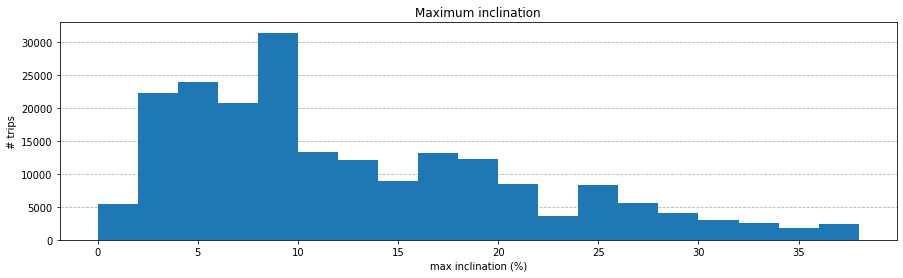

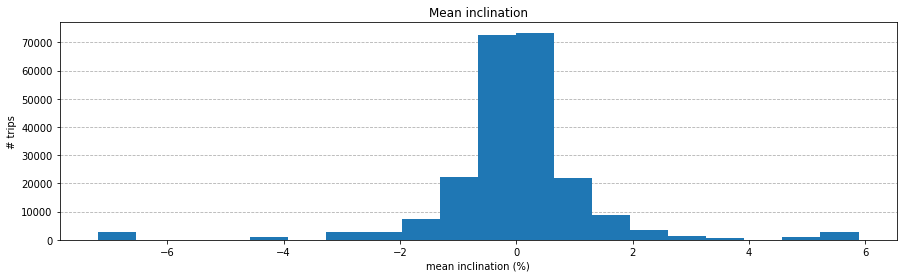

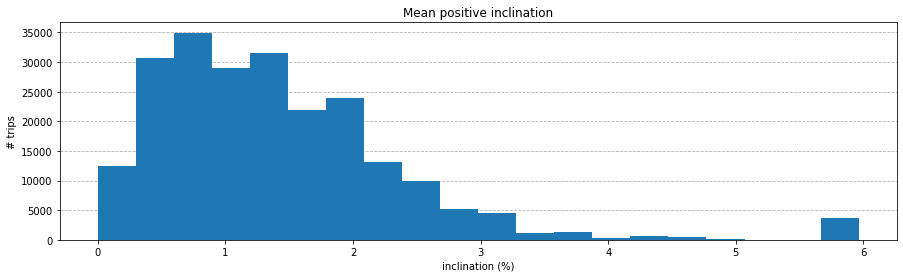

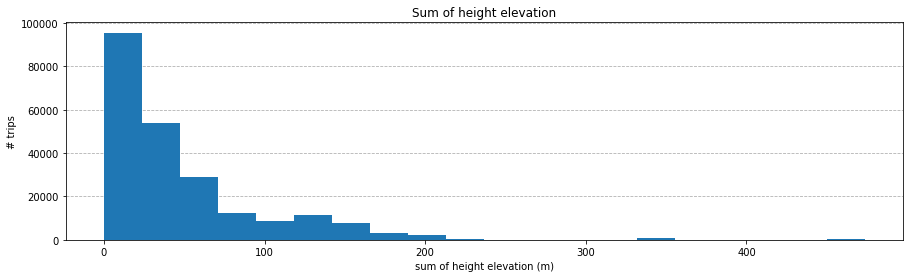

In [8]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=range(0,40,2), x=df_stats['max'], weights = df_stats['fe_via'])
plt.title('Maximum inclination')
plt.xlabel('max inclination (%)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['mean'], weights = df_stats['fe_via'])
plt.title('Mean inclination')
plt.xlabel('mean inclination (%)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['mean_pos'], weights = df_stats['fe_via'])
plt.title('Mean positive inclination')
plt.xlabel('inclination (%)')
plt.ylabel('# trips')
plt.show()
"""
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['std_height'], weights = df_stats['fe_via'])
plt.title('Height Standard Deviation')
plt.xlabel('height standard deviation (m)')
plt.ylabel('# trips')
plt.show()
"""
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=df_stats['sum_elevs'], weights = df_stats['fe_via'])
plt.title('Sum of height elevation')
plt.xlabel('sum of height elevation (m)')
plt.ylabel('# trips')
plt.show()

In [9]:
df_stats['sum_elevs']


x = 0
while x <= 250:
    cyclists = sum(df_stats.loc[df_stats['sum_elevs'] >= x]
                   .loc[df_stats['sum_elevs'] < x + 20]['fe_via'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x + 10) + ', ' + str(cyclists / 1000) + ')')
    x += 20
print('-----------------------------')

x = 0
while x <= 6:
    cyclists = sum(df_stats.loc[df_stats['mean_pos'] >= x]
                   .loc[df_stats['mean_pos'] < x + .20]['fe_via'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x + .10) + ', ' + str(cyclists / 1000) + ')')
    x += .20
print('-----------------------------')
    
x = 0
while x <= 25:
    cyclists = sum(df_stats.loc[df_stats['max'] >= x]
                   .loc[df_stats['max'] < x + 1]['fe_via'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x + .50) + ', ' + str(cyclists / 1000) + ')')
    x += 1


(10, 86.30085377999993)
(30, 48.95485937899997)
(50, 32.62285818599999)
(70, 17.84275285600001)
(90, 6.00998266)
(110, 7.308382631999999)
(130, 10.833852331)
(150, 5.694932325999999)
(170, 5.714609498)
(190, 1.188463287)
(210, 1.084925277)
(230, 0.206804346)
(250, 0.0)
-----------------------------
(0.1, 5.649083396999998)
(0.30000000000000004, 12.497571852)
(0.5, 25.129690473999986)
(0.7000000000000001, 22.809568733999985)
(0.9, 22.174032433000004)
(1.1, 19.513672639000003)
(1.3, 20.912121177)
(1.5, 17.960652308000004)
(1.7, 13.985234011)
(1.9, 13.472914816000001)
(2.0999999999999996, 16.372540566999998)
(2.3, 7.218355719)
(2.5, 9.380848474999997)
(2.7, 2.6009198340000004)
(2.9000000000000004, 3.797611722)
(3.1000000000000005, 2.3217154289999997)
(3.3000000000000007, 1.90081156)
(3.500000000000001, 0.7337053679999999)
(3.700000000000001, 1.1775946469999998)
(3.9000000000000012, 0.4864028609999999)
(4.1000000000000005, 0.0)
(4.300000000000001, 0.5760969420000001)
(4.500000000000001, 0.

In [10]:
for i in range(31):
    print ('(' + str(-15 +i) + ' ' + str(meters_slope_mean[135+i]) + ')')

NameError: name 'meters_slope_mean' is not defined

In [ ]:
print(sum(df_stats.loc[df_stats['mean_pos'] > 2]['fe_via']))
print(sum(df_stats['fe_via']))

### Sum of distances in each level

In [ ]:
y = []
for i in range(0, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    y.append(meters_slope_i)
    
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


In [ ]:

plt.figure(figsize=(6,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(y, positions=range(0,16), showfliers=False)
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.savefig('slopes_boxplot.pgf')
plt.show()

In [ ]:
meters_slope_mean = []
meters_slope = []
meters_slope_center = []
meters_slope_up = []
meters_slope_down = []

for i in range(-150, 150):
    meters_slope_mean.append(sum(df_stats['meters_slope_' + str(i)] * df_stats['fe_via']) / total_trips)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope.append(meters_slope_i)
    
for i in range(5, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_up.append(meters_slope_i)

for i in range(-5, 6):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_center.append(meters_slope_i)
    
for i in range(-5, -16, -1):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_' + str(i)])
    meters_slope_down.append(meters_slope_i)

In [ ]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=31, x=range(-150, 150), weights=meters_slope_mean, range=(-15, 15))
plt.title('Mean of meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,8))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16))
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_center, positions=range(-5,6), showfliers=False)
plt.title('Meters traveled in each slope level (sum of distances)')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

pos = range(5,16)
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_down, positions=pos, showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('- slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_up, positions=range(5,16), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()


plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(1,10), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()


s = stats(df_stats, 'meters_slope_5', 'fe_via')

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=30, x=df_stats['meters_slope_5'], weights=df_stats['fe_via'], range=(0, 500))
plt.title('Meters traveled at slope 5%')
plt.xlabel('meters')
plt.ylabel('# trips')
plt.show()

### Maximum distance in each level

In [ ]:
meters_slope_mean = []
meters_slope = []
meters_slope_center = []
meters_slope_up = []
meters_slope_down = []

for i in range(-150, 150):
    meters_slope_mean.append(sum(df_stats['meters_slope_max_' + str(i)] * df_stats['fe_via']) / total_trips)
    
for i in range(-15, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope.append(meters_slope_i)
    
for i in range(5, 16):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_up.append(meters_slope_i)

for i in range(-5, 6):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_center.append(meters_slope_i)
    
for i in range(-5, -16, -1):
    meters_slope_i = []
    for _, r in df_stats.iterrows():
        for f in range(round(r['fe_via'])):
            meters_slope_i.append(r['meters_slope_max_' + str(i)])
    meters_slope_down.append(meters_slope_i)

In [ ]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=31, x=range(-150, 150), weights=meters_slope_mean, range=(-15, 15))
plt.title('Mean of meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,8))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope, positions=range(-15,16))
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_center, positions=range(-5,6), showfliers=False)
plt.title('Meters traveled in each slope level (max distance)')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.savefig('./images/bike_trips_meters_traveled_slope_level_max_distance')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_up, positions=range(5,16), showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('slope (%)')
plt.ylabel('meters traveled')
plt.show()

pos = range(5,16)
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.boxplot(meters_slope_down, positions=pos, showfliers=False)
plt.title('Meters traveled in each slope level')
plt.xlabel('- slope (%)')
plt.ylabel('meters traveled')
plt.show()

# Trip Reason

In [ ]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(12)], x=od_routes_sp['MOTIVO_D'].loc[od_routes_sp['N_VIAG'] == 1], weights = od_routes_sp['FE_VIA'].loc[od_routes_sp['N_VIAG'] == 1])
plt.title('Destination Trip Reason (first trip)')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(12)], x=od_routes_sp['MOTIVO_D'].loc[od_routes_sp['N_VIAG'] > 1], weights = od_routes_sp['FE_VIA'].loc[od_routes_sp['N_VIAG'] > 1])
plt.title('Destination Trip Reason (last trips)')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.show()

# 1 - Trabalho Indústria
# 2 - Trabalho Comércio
# 3 - Trabalho Serviços
# 4 - Escola/Educação
# 5 - Compras1q
# 6 - Médico/Dentista/Saúde 
# 7 - Recreação/Visitas/Lazer
# 8 - Residência
# 9 - Procurar Emprego
# 10 - Assuntos Pessoais
# 11 - Refeição

# Week Day

In [ ]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(-1,8)], x=od_routes_sp['DIASEMANA'], weights = od_routes_sp['FE_VIA'])
plt.title('Week Day')
plt.ylabel('# trips')
plt.show()

# Day Period

In [ ]:
od_routes_sp['HORA_SAIDA_INT'] = [int(h[:2] + h[3:5]) / 100 for h in od_routes_sp['HORA_SAIDA']]
s = stats(od_routes_sp, 'HORA_SAIDA_INT')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i], 2))
    
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=range(25), x=od_routes_sp['HORA_SAIDA_INT'], weights = od_routes_sp['FE_VIA'])
plt.title('Day Period')
plt.xlabel('hour')
plt.ylabel('# trips')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

# People

In [3]:
od_people = od_routes_sp.groupby('ID_PESS').max()


od_people_FE_PESS = []
for i, r in od_people.iterrows():
    for w in range(round(r['FE_PESS'])):
        od_people_FE_PESS.append(r)
        
od_people_FE_PESS = pd.DataFrame(data = od_people_FE_PESS, columns = od_people.columns)


In [4]:
display(od_people_FE_PESS)

,id,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,ID_DOM,F_DOM,FE_DOM,DOM,CD_ENTRE,...,TIPVG,PAG_VIAG,TP_ESAUTO,VL_EST,PE_BICI,VIA_BICI,TP_ESTBICI,ID_ORDEM,distance,length
20877101,456,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,4,0,0,0.0,1,2,8,457,2.656898,2456.642964
20877101,456,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,4,0,0,0.0,1,2,8,457,2.656898,2456.642964
20877101,456,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,4,0,0,0.0,1,2,8,457,2.656898,2456.642964
20877101,456,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,4,0,0,0.0,1,2,8,457,2.656898,2456.642964
20877101,456,2,36,-23.548697,-46.629849,20877,1,68.750000,877,1,...,4,0,0,0.0,1,2,8,457,2.656898,2456.642964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5011324101,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,1,0,0.0,2,2,3,177357,17.007105,16232.282688
5011324101,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,1,0,0.0,2,2,3,177357,17.007105,16232.282688
5011324101,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,1,0,0.0,2,2,3,177357,17.007105,16232.282688
5011324101,177356,501,24,-23.507275,-46.768835,5011324,0,388.333333,1324,1,...,1,1,0,0.0,2,2,3,177357,17.007105,16232.282688


In [5]:

#distrib_weighted = dist.best_fit_distribution(od_people_FE_PESS['IDADE'], bins = 100)
#distrib_m = dist.best_fit_distribution(od_people_FE_PESS.loc[od_people_FE_PESS['SEXO'] == 1]['IDADE'], bins = 5)
#distrib_m_2 = dist.best_fit_distribution(od_people_FE_PESS.loc[od_people_FE_PESS['SEXO'] == 1]['IDADE'], bins = 20)
#distrib_f = dist.best_fit_distribution(od_people_FE_PESS.loc[od_people_FE_PESS['SEXO'] == 2]['IDADE'], bins = 5)
#print(distrib_m)
#print(distrib_m_2)
#print(distrib_f)
# bins=100
#('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#('dgamma', (0.39638728719946925, 29.000000000000007, 9.770561148311165))

#('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#('dweibull', (0.7423596624388107, 28.999999999999993, 8.493736966849728))

#('johnsonsb', (0.8055797096186554, 2.1136560472330137, -19.37982613926068, 130.04829427120896))
#('gennorm', (0.3515821692724699, 29.0, 0.20540942031825238))

#('foldcauchy', (6.114613850953486, 0.9999999626040696, 4.4346970738639975))

#distrib_weighted = dist.best_fit_distribution(od_people_FE_PESS['IDADE'], bins = 25)
#print(distrib_weighted)
#genextreme', (0.195561684562034, 27.800891741589794, 13.381742809374167))

# ambas com 5 bins:
#masc ('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
#fem: ('loggamma', (897.3569843061273, -2332.923603808461, 347.1732584129129))


# Age

In [ ]:
import scipy.stats as st
#display(distrib_weighted)
s = stats(od_people, 'IDADE', 'FE_PESS')
for i in range(10):
    print('Age  ' + str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(82), x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 20, x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 20, x=od_people.loc[od_people['SEXO'] == 1]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 1]['FE_PESS'])
plt.hist(bins = 20, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()

distance_pdf = dist.make_pdf(st.genextreme, (0.195561684562034, 27.800891741589794, 13.381742809374167))
plt.figure(figsize=(12,8))
ax = distance_pdf.plot(lw=3, label='Modeled distribuition', legend=True)
plt.hist(bins = 20, x=od_people['IDADE'], weights = od_people['FE_PESS'], density=True)
plt.show()

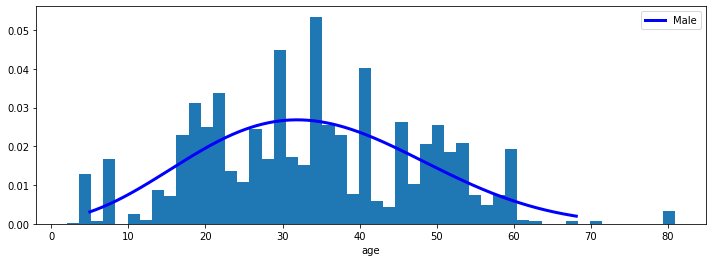

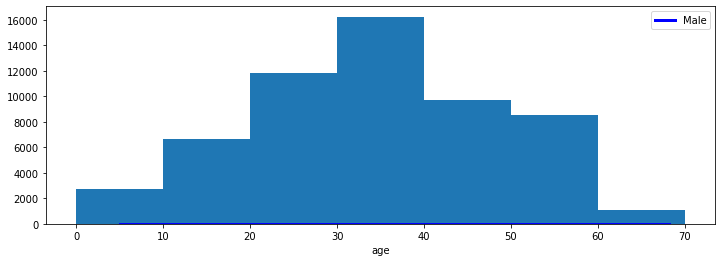

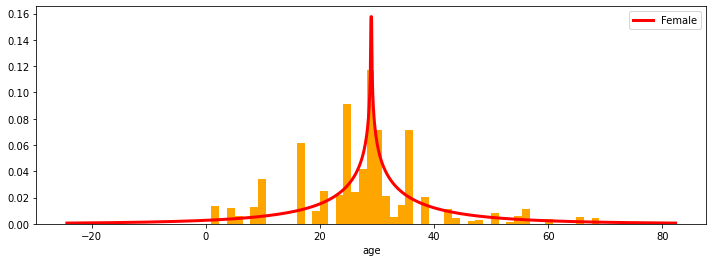

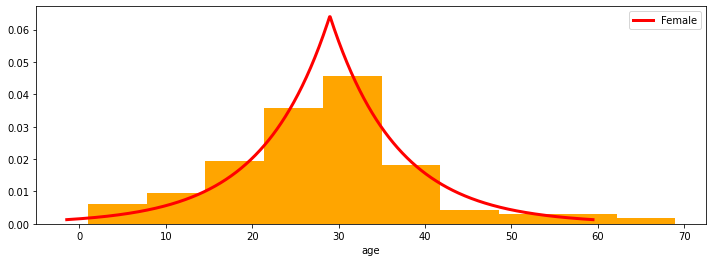

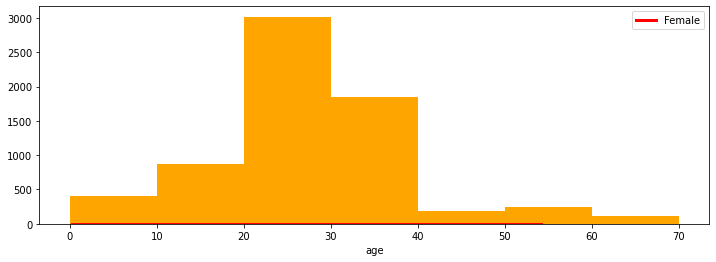

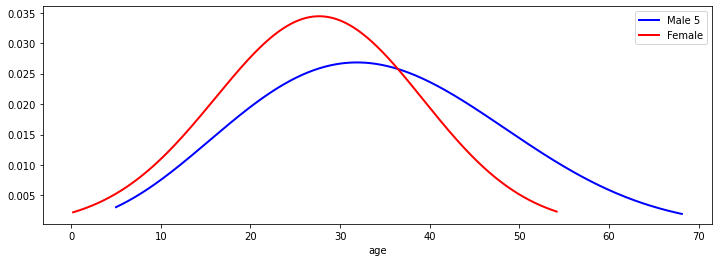

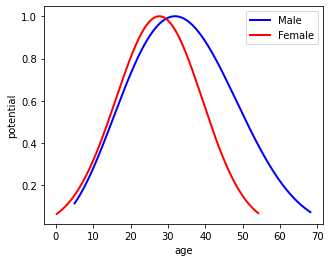

In [19]:
# m 5 ('gausshyper', (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
# f 5 ('loggamma', (897.3569843061273, -2332.923603808461, 347.1732584129129))
# m 20 ('johnsonsb', (0.8055797096186554, 2.1136560472330137, -19.37982613926068, 130.04829427120896))

age_pdf_m = dist.make_pdf(st.gausshyper, (5.279282420419191, 9.427435120845999, 1.7042238760442698, -0.6290314796750072, -9.35105798112198, 113.89907371835868))
age_pdf_f = dist.make_pdf(st.dweibull, (0.7423596624388107, 28.999999999999993, 8.493736966849728))
plt.figure(figsize=(12,4))
plt.hist(bins = 50, x=od_people.loc[od_people['SEXO'] == 1]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 1]['FE_PESS'], density=True)
ax = age_pdf_m.plot(lw=3, label='Male', legend=True, color='blue')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(12,4))
plt.hist(bins = range(0, 80, 10), x = od_people.loc[od_people['SEXO'] == 1]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 1]['FE_PESS'], density=False)
ax = age_pdf_m.plot(lw=3, label='Male', legend=True, color='blue')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(12,4))
plt.hist(bins = 50, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=True, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

age_pdf_f = dist.make_pdf(st.laplace, (29.0, 7.783973688144715))
plt.figure(figsize=(12,4))
plt.hist(bins = 10, x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=True, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

age_pdf_f = dist.make_pdf(st.loggamma, (897.3569843061273, -2332.923603808461, 347.1732584129129))
plt.figure(figsize=(12,4))
plt.hist(bins = range(0, 80, 10), x=od_people.loc[od_people['SEXO'] == 2]['IDADE'], 
         weights = od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], density=False, color = 'orange')
ax = age_pdf_f.plot(lw=3, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

plt.figure(figsize=(12,4))
ax = age_pdf_m.plot(lw=2, label='Male 5', legend=True, color='blue')
ax = age_pdf_f.plot(lw=2, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.show()

max_m = max(d for d in age_pdf_m)
max_f = max(d for d in age_pdf_f)
age_m_scaled = age_pdf_m / max_m
age_f_scaled = age_pdf_f / max_f

plt.figure(figsize=(5,4))
ax = age_m_scaled.plot(lw=2, label='Male', legend=True, color='blue')
ax = age_f_scaled.plot(lw=2, label='Female', legend=True, color='red')
plt.xlabel('age')
plt.ylabel('potential')
plt.show()


# Car Ownership

Cars quantity  10%:	 0.0
Cars quantity  20%:	 0.0
Cars quantity  30%:	 0.0
Cars quantity  40%:	 0.0
Cars quantity  50%:	 0.2
Cars quantity  60%:	 0.25
Cars quantity  70%:	 0.33
Cars quantity  80%:	 0.4
Cars quantity  90%:	 0.5
Cars quantity  100%:	 2.0


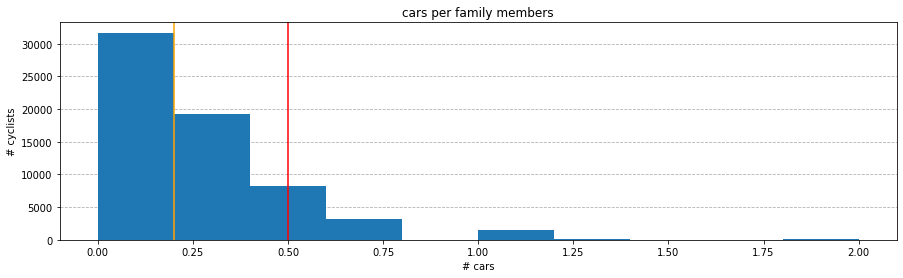

In [20]:
od_people['CARS_PER_FAMILY'] = od_people['QT_AUTO'] / od_people['NO_MORAF']
s = stats(od_people, 'CARS_PER_FAMILY', 'FE_PESS')
for i in range(10):
    print('Cars quantity  ' + str(i + 1) + '0%:\t', round(s[i], 2))
    
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=10, x=od_people['CARS_PER_FAMILY'], weights = od_people['FE_PESS'])
plt.title('cars per family members')
plt.xlabel('# cars')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/bike_trips_cars_per_family_members')
plt.show()

# Economic Classification

10%:	 1
20%:	 2
30%:	 3
40%:	 3
50%:	 4
60%:	 4
70%:	 4
80%:	 5
90%:	 6
100%:	 6


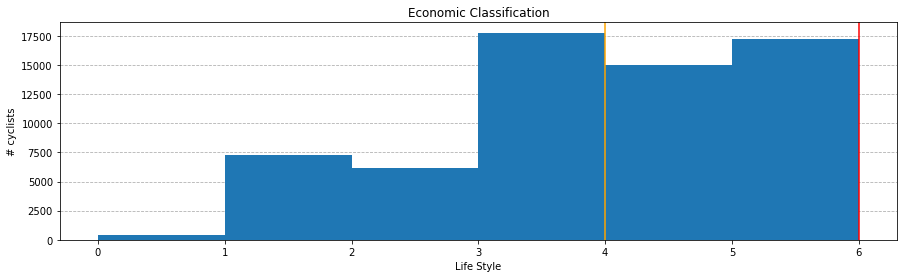

In [21]:
s = stats(od_people, 'CRITERIOBR', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(7), x=od_people['CRITERIOBR'], weights = od_people['FE_PESS'])
plt.title('Economic Classification')
plt.xlabel('Life Style')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/bike_trips_economic_classification')
plt.show()   

# 1 - A
# 2 - B1
# 3 - B2
# 4 - C1
# 5 - C2
# 6 - D - E


10%:	 0
20%:	 0
30%:	 0
40%:	 0
50%:	 0
60%:	 1200
70%:	 1500
80%:	 2000
90%:	 3200
100%:	 20000


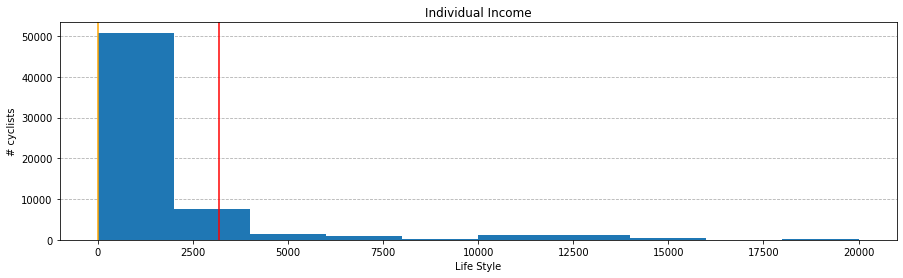

10%:	 425
20%:	 550
30%:	 683
40%:	 900
50%:	 1130
60%:	 1350
70%:	 1793
80%:	 2345
90%:	 3709
100%:	 20000


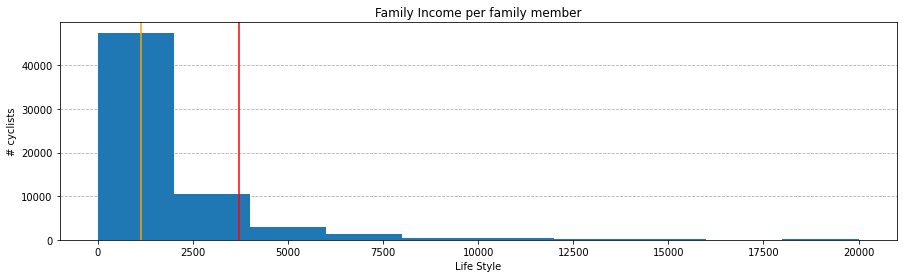

10%:	 1
20%:	 1
30%:	 1
40%:	 1
50%:	 1
60%:	 2
70%:	 3
80%:	 3
90%:	 3
100%:	 6


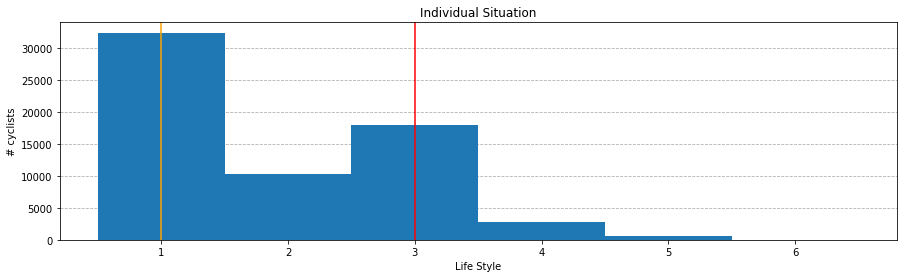

In [22]:
s = stats(od_people, 'VL_REN_I', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(x=od_people['VL_REN_I'], weights = od_people['FE_PESS'])
plt.title('Individual Income')
plt.xlabel('Life Style')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/individual_income')
plt.show()   

od_people['mean_income'] = od_people['RENDA_FA'] / od_people['NO_MORAF']
s = stats(od_people, 'mean_income', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(x=od_people['mean_income'], weights = od_people['FE_PESS'])
plt.title('Family Income per family member')
plt.xlabel('Life Style')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

s = stats(od_people, 'SIT_FAM', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(7)], x=od_people['SIT_FAM'], weights = od_people['FE_PESS'])
plt.title('Individual Situation')
plt.xlabel('Life Style')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

# 1 - Pessoa Responsável
# 2 - Cônjuge/Companheiro(a)
# 3 - Filho(a)/Enteado(a)
# 4 - Outro Parente
# 5 - Agregado
# 6 - Empregado Residente
# 7 - Parente do Empregado Residente

# Education

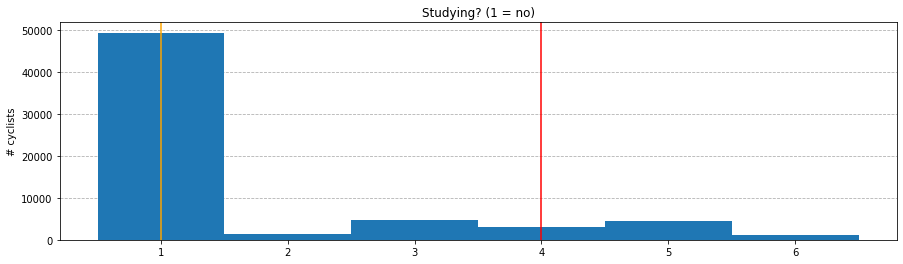

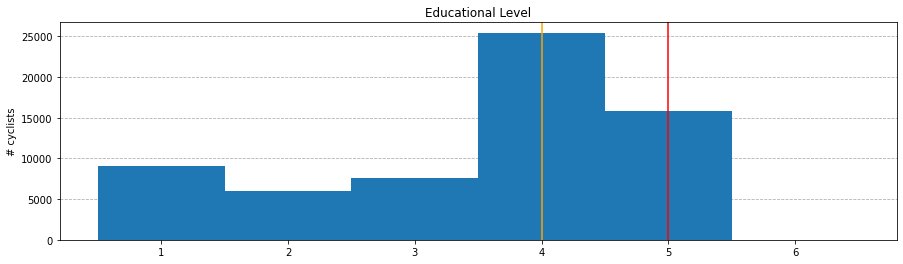

In [23]:
s = stats(od_people, 'ESTUDA', 'FE_PESS')
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(7)], x=od_people['ESTUDA'], weights = od_people['FE_PESS'])
plt.title('Studying? (1 = no)')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

s = stats(od_people, 'GRAU_INS', 'FE_PESS')
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(7)], x=od_people['GRAU_INS'], weights = od_people['FE_PESS'])
plt.title('Educational Level')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

#1 - Não-Alfabetizado/Fundamental I Incompleto
#2 - Fundamental I Completo/Fundamental II Incompleto
#3 - Fundamental II Completo/Médio Incompleto
#4 - Médio Completo/Superior Incompleto
#5 - Superior Completog


# Number of trips

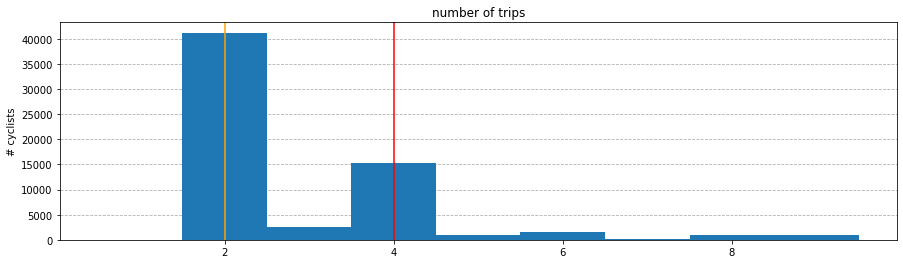

In [24]:
s = stats(od_people, 'TOT_VIAG', 'FE_PESS')
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(10)], x=od_people['TOT_VIAG'], weights = od_people['FE_PESS'])
plt.title('number of trips')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/bike_trips_number_of_trips')
plt.show()   

In [25]:
# ===========================================================================
#
#     Refazendo as estatísticas com os dados completos sobre as pessoas
#
# ===========================================================================

In [6]:
od_trips = pd.read_csv('../data/sao-paulo/od/OD_2017.csv')
od_trips.columns = [c[: c.index(',')] for c in od_trips.columns]
od_trips.set_index('ID_ORDEM', inplace=True, drop=False)

od_people = od_trips.loc[od_trips['MODOPRIN'] == 15].groupby('ID_PESS').max()

od_people_FE_PESS = []
for i, r in od_people.iterrows():
    for w in range(round(r['FE_PESS'])):
        od_people_FE_PESS.append(r)
        
od_people_FE_PESS = pd.DataFrame(data = od_people_FE_PESS, columns = od_people.columns)

In [7]:
display(od_people_FE_PESS)
od_bike_trips = od_trips.loc[od_trips['MODOPRIN'] == 15]
display(od_bike_trips)
display(sum(od_bike_trips['FE_VIA']))

,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,ID_DOM,F_DOM,FE_DOM,DOM,CD_ENTRE,DATA,...,DURACAO,MODOPRIN,TIPVG,PAG_VIAG,TP_ESAUTO,VL_EST,PE_BICI,VIA_BICI,TP_ESTBICI,ID_ORDEM
20877101,2.0,36.0,333638.0,7394792.0,20877.0,1.0,68.750000,877.0,1.0,2082018.0,...,10.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,8.0,457.0
20877101,2.0,36.0,333638.0,7394792.0,20877.0,1.0,68.750000,877.0,1.0,2082018.0,...,10.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,8.0,457.0
20877101,2.0,36.0,333638.0,7394792.0,20877.0,1.0,68.750000,877.0,1.0,2082018.0,...,10.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,8.0,457.0
20877101,2.0,36.0,333638.0,7394792.0,20877.0,1.0,68.750000,877.0,1.0,2082018.0,...,10.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,8.0,457.0
20877101,2.0,36.0,333638.0,7394792.0,20877.0,1.0,68.750000,877.0,1.0,2082018.0,...,10.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,8.0,457.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5162821103,516.0,31.0,312175.0,7402685.0,5162821.0,0.0,291.658537,2821.0,1.0,6102018.0,...,15.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,1.0,182653.0
5162821103,516.0,31.0,312175.0,7402685.0,5162821.0,0.0,291.658537,2821.0,1.0,6102018.0,...,15.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,1.0,182653.0
5162821103,516.0,31.0,312175.0,7402685.0,5162821.0,0.0,291.658537,2821.0,1.0,6102018.0,...,15.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,1.0,182653.0
5162821103,516.0,31.0,312175.0,7402685.0,5162821.0,0.0,291.658537,2821.0,1.0,6102018.0,...,15.0,15.0,4.0,0.0,0.0,0.0,1.0,2.0,1.0,182653.0


,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,ID_DOM,F_DOM,FE_DOM,DOM,CD_ENTRE,DATA,...,DURACAO,MODOPRIN,TIPVG,PAG_VIAG,TP_ESAUTO,VL_EST,PE_BICI,VIA_BICI,TP_ESTBICI,ID_ORDEM
ID_ORDEM,,,,,,,,,,,,,,,,,,,,,
450,2,36,333638,7394792,20877,1,68.750000,877,1,2082018,...,10,15,4,0,0,0.0,1,2,8,450
451,2,36,333638,7394792,20877,0,68.750000,877,1,2082018,...,10,15,4,0,0,0.0,1,2,3,451
452,2,36,333638,7394792,20877,0,68.750000,877,1,2082018,...,10,15,4,0,0,0.0,1,2,8,452
453,2,36,333638,7394792,20877,0,68.750000,877,1,2082018,...,10,15,4,0,0,0.0,1,2,3,453
454,2,36,333638,7394792,20877,0,68.750000,877,1,2082018,...,10,15,4,0,0,0.0,1,2,8,454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181110,513,17,297051,7391506,5130534,0,76.700000,534,1,23062018,...,60,15,4,0,0,0.0,4,2,3,181110
181997,515,17,301914,7392584,5150582,0,401.953543,582,1,4052018,...,15,15,4,0,0,0.0,1,2,3,181997
181998,515,17,301914,7392584,5150582,0,401.953543,582,1,4052018,...,25,15,4,0,0,0.0,1,2,3,181998


376975.23400600004

Age  10%:	 17
Age  20%:	 20
Age  30%:	 24
Age  40%:	 29
Age  50%:	 34
Age  60%:	 37
Age  70%:	 42
Age  80%:	 48
Age  90%:	 53
Age  100%:	 81


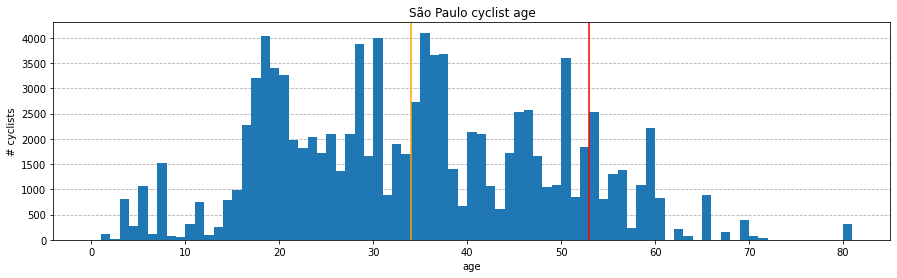

In [8]:
s = stats(od_people, 'IDADE', 'FE_PESS')
for i in range(10):
    print('Age  ' + str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(82), x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.show()   

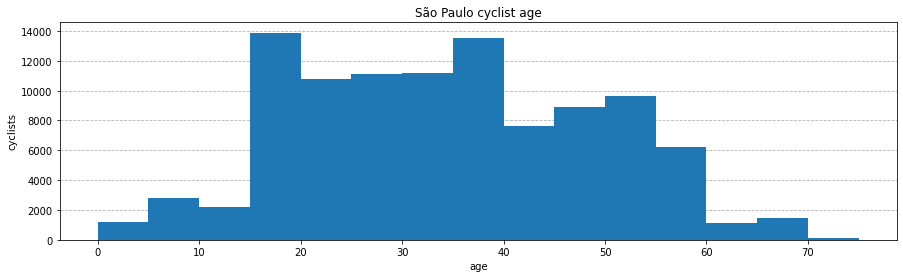

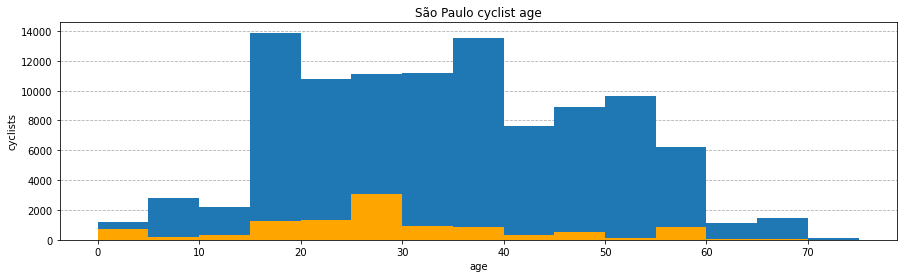

In [9]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = range(0,80,5), x=od_people['IDADE'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('cyclists')
plt.show()   

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(
    bins = range(0, 80, 5), 
    x = [od_people.loc[od_people['SEXO'] == 2]['IDADE'], od_people.loc[od_people['SEXO'] == 1]['IDADE']],
    weights = [od_people.loc[od_people['SEXO'] == 2]['FE_PESS'], od_people.loc[od_people['SEXO'] == 1]['FE_PESS']],
    label = ['Male', 'Female'],
    color = ['orange', '#1f77b4'],
    histtype = 'barstacked')
plt.title('São Paulo cyclist age')
plt.xlabel('age')
plt.ylabel('cyclists')
plt.show()    

In [54]:
display(sum(od_people['FE_PESS']))

for s in [1, 2]:
    age = 0
    while age <= 85:
        cyclists = sum(od_people.loc[od_people['SEXO'] == s].loc[od_people['IDADE'] >= age].loc[od_people['IDADE'] < age + 5]['FE_PESS'])
        #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
        print('(' + str(age + 2.5) + ', ' + str(cyclists / 1000) + ')')
        age += 5
    print ('-------------------')


102069.09576200003

(2.5, 0.501420584)
(7.5, 2.6494282850000004)
(12.5, 1.8943469569999998)
(17.5, 12.607775791000003)
(22.5, 9.466103854)
(27.5, 7.981424106999999)
(32.5, 10.283835427999996)
(37.5, 12.671488578999998)
(42.5, 7.2632337819999995)
(47.5, 8.345315259000001)
(52.5, 9.520872378)
(57.5, 5.3709647160000005)
(62.5, 1.0908688439999998)
(67.5, 1.3606188650000002)
(72.5, 0.10788381699999999)
(77.5, 0.0)
(82.5, 0.30986187)
(87.5, 0.0)
-------------------
(2.5, 0.719980221)
(7.5, 0.17180107)
(12.5, 0.312377205)
(17.5, 1.2779697)
(22.5, 1.345162097)
(27.5, 3.1025182829999998)
(32.5, 0.9117382970000001)
(37.5, 0.8313856859999998)
(42.5, 0.34219680199999997)
(47.5, 0.547539136)
(52.5, 0.088477897)
(57.5, 0.874909263)
(62.5, 0.030770913)
(67.5, 0.086826076)
(72.5, 0.0)
(77.5, 0.0)
(82.5, 0.0)
(87.5, 0.0)
-------------------


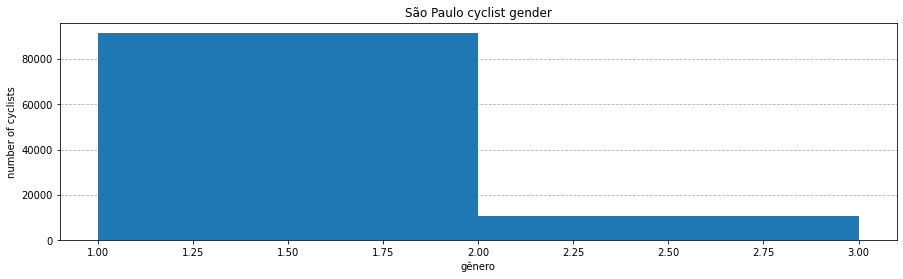

In [10]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = [1,2,3], x=od_people['SEXO'], weights = od_people['FE_PESS'])
plt.title('São Paulo cyclist gender')
plt.xlabel('gênero')
plt.ylabel('number of cyclists')
#plt.axvline(x=s[4],color='orange')
#plt.axvline(x=s[8],color='red')
plt.show()   

In [11]:
print(sum(od_people.loc[od_people['SEXO'] == 1]['FE_PESS']))
print(sum(od_people.loc[od_people['SEXO'] == 2]['FE_PESS']))

91425.44311600002
10643.652645999999


In [12]:
print(sum(od_people['FE_PESS']))
print(sum(od_people.loc[od_people['ESTUDA'] == 1]['FE_PESS']))
print(sum(od_people.loc[od_people['GRAU_INS'] < 4]['FE_PESS']))
print(sum(od_people.loc[od_people['GRAU_INS'] ==4]['FE_PESS']))
print(sum(od_people.loc[od_people['GRAU_INS'] ==5]['FE_PESS']))

102069.09576200003
81470.13647200003
45403.84891300001
41308.880197
15356.366651999999


In [34]:
for c in od_people.columns:
    print(c)

ZONA
MUNI_DOM
CO_DOM_X
CO_DOM_Y
ID_DOM
F_DOM
FE_DOM
DOM
CD_ENTRE
DATA
TIPO_DOM
AGUA
RUA_PAVI
NO_MORAD
TOT_FAM
ID_FAM
F_FAM
FE_FAM
FAMILIA
NO_MORAF
CONDMORA
QT_BANHO
QT_EMPRE
QT_AUTO
QT_MICRO
QT_LAVALOU
QT_GEL1
QT_GEL2
QT_FREEZ
QT_MLAVA
QT_DVD
QT_MICROON
QT_MOTO
QT_SECAROU
QT_BICICLE
NAO_DCL_IT
CRITERIOBR
PONTO_BR
ANO_AUTO1
ANO_AUTO2
ANO_AUTO3
RENDA_FA
CD_RENFA
F_PESS
FE_PESS
PESSOA
SIT_FAM
IDADE
SEXO
ESTUDA
GRAU_INS
CD_ATIVI
CO_REN_I
VL_REN_I
ZONA_ESC
MUNIESC
CO_ESC_X
CO_ESC_Y
TIPO_ESC
ZONATRA1
MUNITRA1
CO_TR1_X
CO_TR1_Y
TRAB1_RE
TRABEXT1
OCUP1
SETOR1
VINC1
ZONATRA2
MUNITRA2
CO_TR2_X
CO_TR2_Y
TRAB2_RE
TRABEXT2
OCUP2
SETOR2
VINC2
N_VIAG
FE_VIA
DIA_SEM
TOT_VIAG
ZONA_O
MUNI_O
CO_O_X
CO_O_Y
ZONA_D
MUNI_D
CO_D_X
CO_D_Y
ZONA_T1
MUNI_T1
CO_T1_X
CO_T1_Y
ZONA_T2
MUNI_T2
CO_T2_X
CO_T2_Y
ZONA_T3
MUNI_T3
CO_T3_X
CO_T3_Y
MOTIVO_O
MOTIVO_D
SERVIR_O
SERVIR_D
MODO1
MODO2
MODO3
MODO4
H_SAIDA
MIN_SAIDA
ANDA_O
H_CHEG
MIN_CHEG
ANDA_D
DURACAO
MODOPRIN
TIPVG
PAG_VIAG
TP_ESAUTO
VL_EST
PE_BICI
VIA_BICI
TP_EST

0.0
0.0
0.0
0.0
0.0
1000.0
1200.0
1500.0
2000.0
20000.0


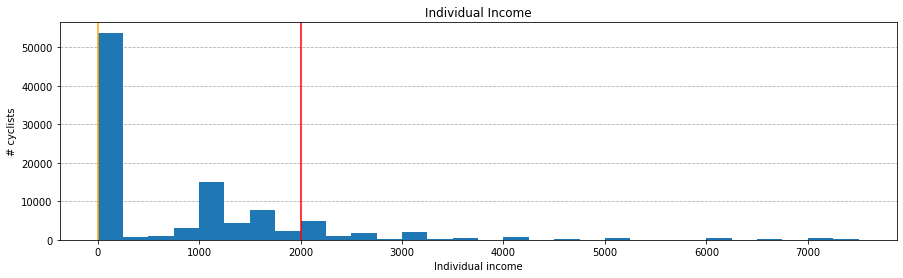

10%:	 316
20%:	 494
30%:	 624
40%:	 767
50%:	 967
60%:	 1130
70%:	 1400
80%:	 1800
90%:	 2667
100%:	 20000


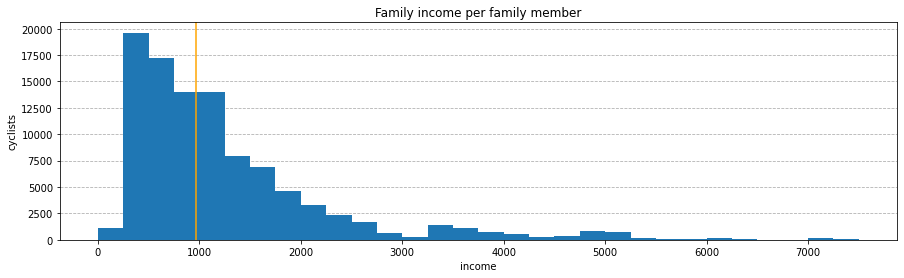

In [35]:
s = stats(od_people, 'VL_REN_I', 'FE_PESS')
for i in s:
    print(i)

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 30, x = od_people['VL_REN_I'], weights = od_people['FE_PESS'], range=(0,7500))
plt.title('Individual Income')
plt.xlabel('Individual income')
plt.ylabel('# cyclists')
plt.axvline(x=s[4],color='orange')
plt.axvline(x=s[8],color='red')
plt.savefig('./images/individual_income')
plt.show()   



od_people['mean_income'] = od_people['RENDA_FA'] / od_people['NO_MORAF']
s = stats(od_people, 'mean_income', 'FE_PESS')
for i in range(10):
    print(str(i + 1) + '0%:\t', round(s[i]))
  
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins = 30,x=od_people['mean_income'], weights = od_people['FE_PESS'], range=(0,7500))
plt.title('Family income per family member')
plt.xlabel('income')
plt.ylabel('cyclists')
plt.axvline(x=s[4],color='orange')
#plt.axvline(x=s[8],color='red')
plt.show() 

In [62]:
display(sum(od_people['FE_PESS']))

income = 0
while income <= 6000:
    cyclists = sum(od_people.loc[od_people['mean_income'] >= income]
                   .loc[od_people['mean_income'] < income + 200]['FE_PESS'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(income + 100) + ', ' + str(cyclists / 1000) + ')')
    income += 200

102069.09576200003

(100, 0.512710503)
(300, 14.124325831999998)
(500, 14.181447151000004)
(700, 13.451961343)
(900, 9.693631821999999)
(1100, 11.314953286)
(1300, 6.744038764000001)
(1500, 5.414034792000001)
(1700, 6.201919408000001)
(1900, 3.814942969)
(2100, 1.901695548)
(2300, 3.5357713260000008)
(2500, 0.601987755)
(2700, 1.6102952890000002)
(2900, 0.32249289500000006)
(3100, 0.20345585800000002)
(3300, 1.172412526)
(3500, 1.227402401)
(3700, 0.335587491)
(3900, 0.608369001)
(4100, 0.553638259)
(4300, 0.06277994099999999)
(4500, 0.28263227500000004)
(4700, 0.52149752)
(4900, 0.6548148220000001)
(5100, 0.699539268)
(5300, 0.196556396)
(5500, 0.048444041)
(5700, 0.051266711)
(5900, 0.091757982)
(6100, 0.185309794)


In [36]:
print(sum(od_people['FE_PESS']))
od_people['cars_per_capita'] =  od_people['QT_AUTO'] / od_people['NO_MORAF']
print(sum(od_people.loc[od_people['QT_AUTO'] == 0]['FE_PESS']))
print(sum(od_people.loc[od_people['QT_AUTO'] >= 1]['FE_PESS']))

102069.09576200003
58434.561057
43634.53470499999


ID_PESS
20877101      0.0
20877102      0.0
20877103      0.0
41216101      0.0
41230101      0.0
             ... 
5060023101    0.0
5110030101    0.0
5130534101    0.0
5150582103    0.0
5162821103    2.0
Name: members_per_car, Length: 566, dtype: float64

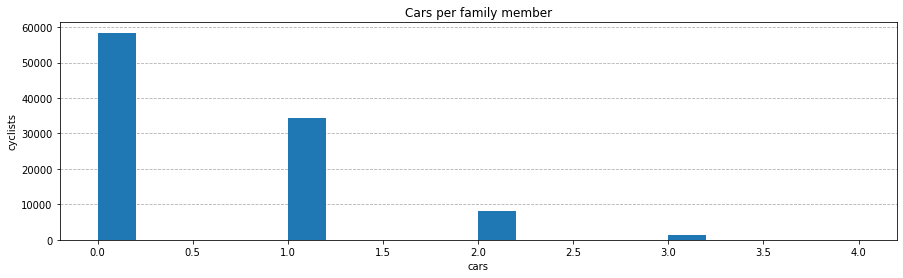

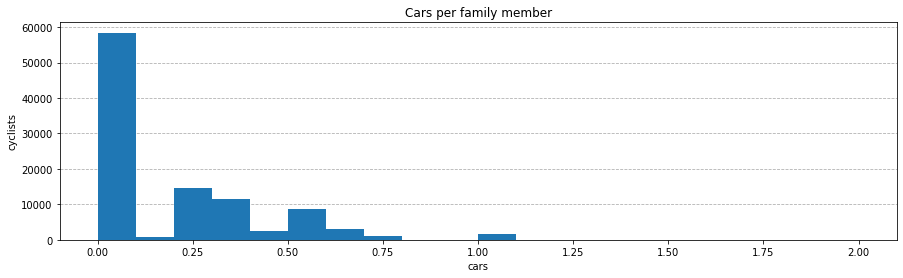

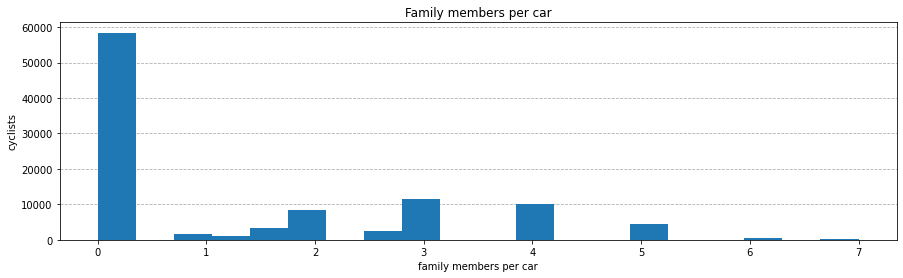

In [63]:
od_people['cars_per_capita'] =  od_people['QT_AUTO'] / od_people['NO_MORAF']

od_people['members_per_car'] = [0 if r['QT_AUTO'] == 0 else r['NO_MORAF'] / r['QT_AUTO'] 
                                for _, r in od_people.iterrows()]

display(od_people['members_per_car'])

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=od_people['QT_AUTO'], weights = od_people['FE_PESS'])
plt.title('Cars per family member')
plt.xlabel('cars')
plt.ylabel('cyclists')
#plt.axvline(x=s[4],color='orange')
#plt.axvline(x=s[8],color='red')
plt.show() 

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=od_people['cars_per_capita'], weights = od_people['FE_PESS'])
plt.title('Cars per family member')
plt.xlabel('cars')
plt.ylabel('cyclists')
#plt.axvline(x=s[4],color='orange')
#plt.axvline(x=s[8],color='red')
plt.show() 


plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=20, x=od_people['members_per_car'], weights = od_people['FE_PESS'])
plt.title('Family members per car')
plt.xlabel('family members per car')
plt.ylabel('cyclists')
#plt.axvline(x=s[4],color='orange')
#plt.axvline(x=s[8],color='red')
plt.show() 


In [68]:
print(sum(od_people.loc[od_people['members_per_car'] > 2]['FE_PESS']))

display(sum(od_people['FE_PESS']))

member = 0
while member <= 10:
    cyclists = sum(od_people.loc[od_people['QT_AUTO'] >= 1]
                            .loc[od_people['members_per_car'] >= member]
                   .loc[od_people['members_per_car'] < member + 1]['FE_PESS'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(member) + ', ' + str(cyclists / 1000) + ')')
    member += 1
    

member = 0
while member <= 10:
    cyclists = sum(od_people.loc[od_people['QT_AUTO'] >= member]
                   .loc[od_people['QT_AUTO'] < member + 1]['FE_PESS'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(member) + ', ' + str(cyclists / 1000) + ')')
    member += 1

29300.349467999993


102069.09576200003

(0, 0.132795251)
(1, 5.787282989000001)
(2, 10.761665375999998)
(3, 11.641630450000001)
(4, 10.234060259)
(5, 4.317643795)
(6, 0.502678609)
(7, 0.256777976)
(8, 0.0)
(9, 0.0)
(10, 0.0)
(0, 58.434561056999996)
(1, 34.315169647999994)
(2, 8.009519319999999)
(3, 1.258569008)
(4, 0.051276729)
(5, 0.0)
(6, 0.0)
(7, 0.0)
(8, 0.0)
(9, 0.0)
(10, 0.0)


In [39]:
########################################
#
#    Estatísticas das viagens
#
########################################

In [40]:
od_bike_trips = od_trips.loc[od_trips['MODOPRIN'] == 15]

In [41]:
print(sum(od_bike_trips['FE_VIA']))

376975.23400600004


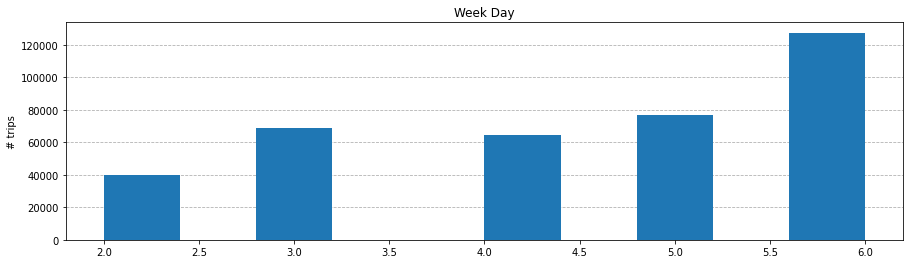

In [42]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist( x=od_bike_trips['DIA_SEM'], weights = od_bike_trips['FE_VIA'])
plt.title('Week Day')
plt.ylabel('# trips')
plt.show()

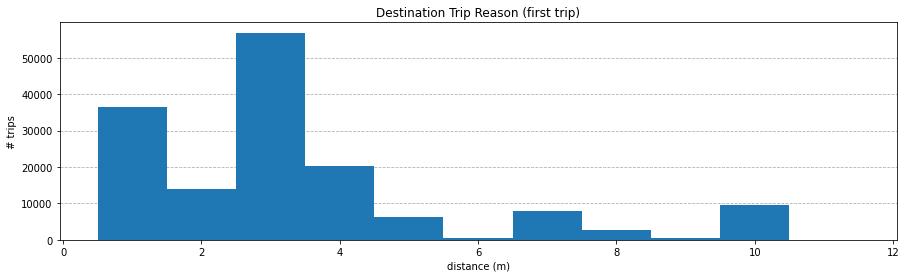

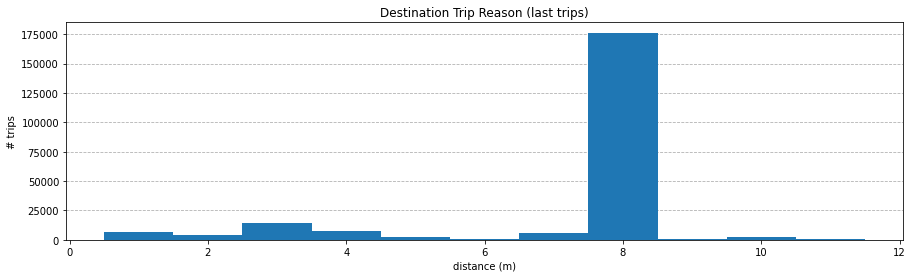

In [69]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(12)], x=od_bike_trips['MOTIVO_D'].loc[od_bike_trips['N_VIAG'] == 1], weights = od_bike_trips['FE_VIA'].loc[od_bike_trips['N_VIAG'] == 1])
plt.title('Destination Trip Reason (first trip)')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.show()

plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=[i + 0.5 for i in range(12)], x=od_bike_trips['MOTIVO_D'].loc[od_bike_trips['N_VIAG'] > 1], weights = od_bike_trips['FE_VIA'].loc[od_bike_trips['N_VIAG'] > 1])
plt.title('Destination Trip Reason (last trips)')
plt.xlabel('distance (m)')
plt.ylabel('# trips')
plt.show()

# 1 - Trabalho Indústria
# 2 - Trabalho Comércio
# 3 - Trabalho Serviços
# 4 - Escola/Educação
# 5 - Compras1q
# 6 - Médico/Dentista/Saúde 
# 7 - Recreação/Visitas/Lazer
# 8 - Residência
# 9 - Procurar Emprego
# 10 - Assuntos Pessoais
# 11 - Refeição

In [74]:
print(sum(od_bike_trips.loc[od_bike_trips['N_VIAG'] <= 1]['FE_VIA']))
print(sum(od_bike_trips.loc[od_bike_trips['N_VIAG'] > 1]['FE_VIA']))

x = 0 #dado para contar
while x <= 11:
    cyclists = sum(od_bike_trips.loc[od_bike_trips['MOTIVO_D'] == x]
                   .loc[od_bike_trips['N_VIAG'] == 1]['FE_VIA'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x) + ', ' + str(cyclists / 1000) + ')')
    x += 1
x = 0 #dado para contar
while x <= 11:
    cyclists = sum(od_bike_trips.loc[od_bike_trips['MOTIVO_D'] == x]
                   .loc[od_bike_trips['N_VIAG'] > 1]['FE_VIA'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x) + ', ' + str(cyclists / 1000) + ')')
    x += 1

155169.80501500008
221805.42899099973
(0, 0.0)
(1, 36.480031806999996)
(2, 14.013385111)
(3, 56.869668923999996)
(4, 20.297251334)
(5, 6.125669964000001)
(6, 0.537195373)
(7, 7.9451220540000005)
(8, 2.790450622)
(9, 0.599960475)
(10, 9.511069351)
(11, 0.0)
(0, 0.0)
(1, 6.455719929999999)
(2, 4.50894493)
(3, 14.490769806000005)
(4, 7.881820936)
(5, 2.479073958)
(6, 0.470312138)
(7, 5.765316702)
(8, 176.28942902099993)
(9, 0.376420896)
(10, 2.6302759739999995)
(11, 0.4573447)
(0, 0.0)
(1, 36.480031806999996)
(2, 14.013385111)
(3, 56.869668923999996)
(4, 20.297251334)
(5, 6.125669964000001)
(6, 0.537195373)
(7, 7.9451220540000005)
(8, 2.790450622)
(9, 0.599960475)
(10, 9.511069351)
(11, 0.0)
(0, 0.0)
(1, 6.455719929999999)
(2, 4.50894493)
(3, 14.490769806000005)
(4, 7.881820936)
(5, 2.479073958)
(6, 0.470312138)
(7, 5.765316702)
(8, 176.28942902099993)
(9, 0.376420896)
(10, 2.6302759739999995)
(11, 0.4573447)


In [75]:
print(sum(od_bike_trips['FE_VIA']))

x = 0 #dado para contar
while x <= 25:
    cyclists = sum(od_bike_trips.loc[od_bike_trips['H_SAIDA'] >= x]
                   .loc[od_bike_trips['H_SAIDA'] < x+1]['FE_VIA'])
    #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
    print('(' + str(x) + ', ' + str(cyclists / 1000) + ')')
    x += 1

376975.23400600004
(0, 2.30814652)
(1, 1.877541642)
(2, 0.6552192769999999)
(3, 0.210479426)
(4, 3.6662344779999994)
(5, 12.806604477000002)
(6, 35.249327318999995)
(7, 45.63728053199999)
(8, 17.592404713)
(9, 15.806820184)
(10, 10.413669437000003)
(11, 9.211080175000001)
(12, 29.238275640000005)
(13, 22.103357632000005)
(14, 14.555459501)
(15, 17.658510355999997)
(16, 21.988167662)
(17, 50.573509595)
(18, 31.237997599999996)
(19, 15.495346450999996)
(20, 5.2288197610000005)
(21, 5.04574296)
(22, 7.955139829000002)
(23, 0.460098839)
(24, 0.0)
(25, 0.0)


In [ ]:
H_SAIDA

In [1]:
import saopaulo.sp_grid as gr
import bikescience.distributions as dist
from bikescience.slope import plot_slope, plot_slopes, split_route

import folium
import pandas as pd
import geopandas as gpd
from statistics import stdev
from ipywidgets import interact_manual, widgets, fixed
from IPython.core.display import display, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import warnings
import requests
import os
warnings.simplefilter('ignore')
import time

od_trips = pd.read_csv('../data/sao-paulo/od/OD_2017.csv')
od_trips.columns = [c[: c.index(',')] for c in od_trips.columns]
od_trips.set_index('ID_ORDEM', inplace=True, drop=False)

/home/pedro/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
display(od_trips)

,ZONA,MUNI_DOM,CO_DOM_X,CO_DOM_Y,ID_DOM,F_DOM,FE_DOM,DOM,CD_ENTRE,DATA,...,DURACAO,MODOPRIN,TIPVG,PAG_VIAG,TP_ESAUTO,VL_EST,PE_BICI,VIA_BICI,TP_ESTBICI,ID_ORDEM
ID_ORDEM,,,,,,,,,,,,,,,,,,,,,
1,1,36,333743,7394463,10001,1,15.416667,1,1,6092017,...,10,16,3,0,0,0.0,1,0,0,1
2,1,36,333743,7394463,10001,0,15.416667,1,1,6092017,...,10,16,3,0,0,0.0,1,0,0,2
3,1,36,333743,7394463,10001,0,15.416667,1,1,6092017,...,50,1,1,2,0,0.0,0,0,0,3
4,1,36,333743,7394463,10001,0,15.416667,1,1,6092017,...,60,1,1,2,0,0.0,0,0,0,4
5,1,36,333743,7394463,10001,0,15.416667,1,1,6092017,...,40,12,2,0,0,0.0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183088,517,25,294618,7410518,5171418,0,85.531250,1418,1,15092018,...,30,16,3,0,0,0.0,1,0,0,183088
183089,517,25,295243,7411456,5171599,1,52.500000,1599,1,15092018,...,10,16,3,0,0,0.0,1,0,0,183089
183090,517,25,295243,7411456,5171599,0,52.500000,1599,1,15092018,...,10,16,3,0,0,0.0,1,0,0,183090


## Comparações de bicicletas com outrs modais

In [3]:
od_people = od_trips.groupby('ID_PESS').max()
od_ciclistas = od_trips.loc[od_trips['MODOPRIN'] == 15].groupby('ID_PESS').max()

#od_people_FE_PESS = []
#for i, r in od_people.iterrows():
#    for w in range(round(r['FE_PESS'])):
#        od_people_FE_PESS.append(r)
        
#od_people_FE_PESS = pd.DataFrame(data = od_people_FE_PESS, columns = od_people.columns)

#od_ciclistas_FE_PESS = []
#for i, r in od_people.iterrows():
#    for w in range(round(r['FE_PESS'])):
#        od_ciclistas_FE_PESS.append(r)
        
#od_people_FE_PESS = pd.DataFrame(data = od_people_FE_PESS, columns = od_people.columns)

In [4]:
display(sum(od_ciclistas['FE_PESS']))
display(sum(od_people['FE_PESS']))

102069.09576200003

20821670.871776566

In [14]:
def compara_bike_geral(coluna, bins = 10):
    od_col_ciclistas = od_ciclistas.groupby(coluna).sum('FE_PESS')
    od_col_geral = od_people.groupby(coluna).sum('FE_PESS')
    
    od_col_ciclistas['aux'] = od_col_ciclistas.index
    od_col_geral['aux'] = od_col_geral.index
    
    plt.figure(figsize=(15,4))
    ax_distance = plt.axes()
    ax_distance.set_axisbelow(True)
    plt.grid(linestyle='--')
    ax_distance.xaxis.grid(False)
    plt.hist(bins = bins, x=od_col_geral['aux'], weights = od_col_geral['FE_PESS'], density = True)
    plt.title(coluna + ' (geral)')
    plt.xlabel(coluna)
    plt.ylabel('# pessoas')
    plt.show()

    plt.figure(figsize=(15,4))
    ax_distance = plt.axes()
    ax_distance.set_axisbelow(True)
    plt.grid(linestyle='--')
    ax_distance.xaxis.grid(False)
    plt.hist(bins = bins, x=od_col_ciclistas['aux'], weights = od_col_ciclistas['FE_PESS'], density = True)
    plt.title(coluna + '(ciclistas)')
    plt.xlabel(coluna)
    plt.ylabel('# pessoas')
    plt.show()

    display()
    
def print_values(df, column, step): 
    total = sum(df['FE_VIA'])
    print(total)
    max_value = max(df[column])
    x = 0 #dado para contar
    while x <= max_value + step:
        cyclists = sum(df.loc[df[column] >= x]
                       .loc[df[column]< x+step]['FE_VIA'])
        #print(str(age) + ' - ' + str(age + 5) + ':  \t' + str(cyclists))
        print('(' + str(x + step/2) + ', ' + str(cyclists / total) + ')')
        x += step

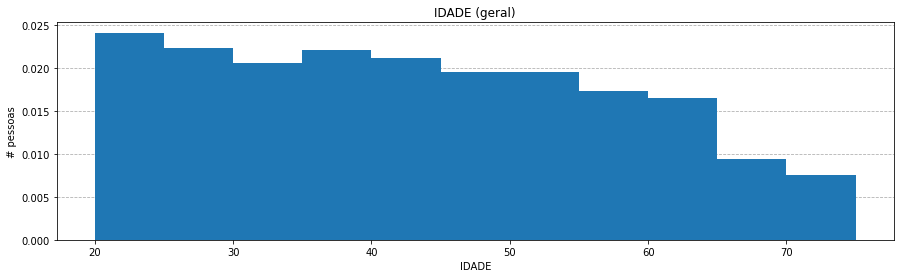

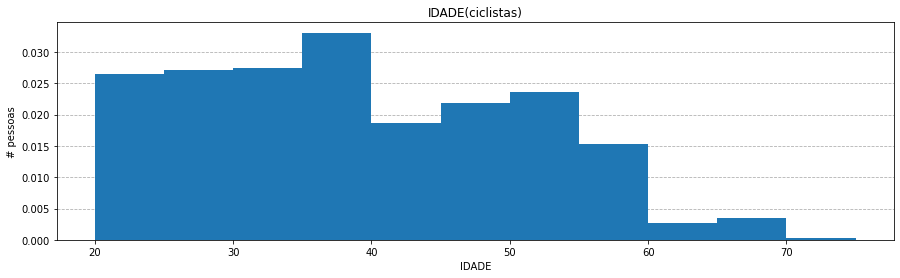

167760.362563
(2.5, 0.011966411518967218)
(7.5, 0.02764038745003699)
(12.5, 0.021619905081201443)
(17.5, 0.13604260315918973)
(22.5, 0.10592105150778375)
(27.5, 0.10859254026801875)
(32.5, 0.10968622428966056)
(37.5, 0.1322915047508057)
(42.5, 0.07451256939973355)
(47.5, 0.08712582714233864)
(52.5, 0.09414554133470493)
(57.5, 0.061192606162524615)
(62.5, 0.010989024146318778)
(67.5, 0.014181030319999427)
(72.5, 0.001056968483442631)
(77.5, 0.0)
(82.5, 0.00303580498527323)
(87.5, 0.0)
16829270.88803827
(2.5, 0.05372255056139204)
(7.5, 0.075792277975786)
(12.5, 0.09052178912592151)
(17.5, 0.08200148501316724)
(22.5, 0.08622873681149491)
(27.5, 0.08205068409710364)
(32.5, 0.0765069068843121)
(37.5, 0.08423707259038943)
(42.5, 0.07786734853631887)
(47.5, 0.07019512510174503)
(52.5, 0.06671102746738591)
(57.5, 0.0559044155547888)
(62.5, 0.046423872059561805)
(67.5, 0.02351988034652993)
(72.5, 0.014487669283420768)
(77.5, 0.00740997309875357)
(82.5, 0.004180541536888953)
(87.5, 0.00170590406

In [16]:
compara_bike_geral('IDADE', bins = range(20,80,5))

print_values(od_ciclistas, 'IDADE', 5)
print_values(od_people, 'IDADE', 5)

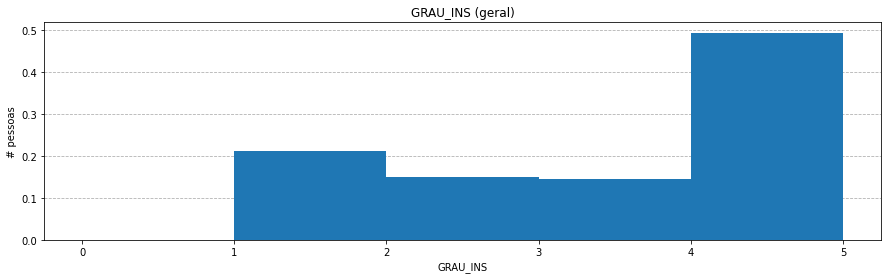

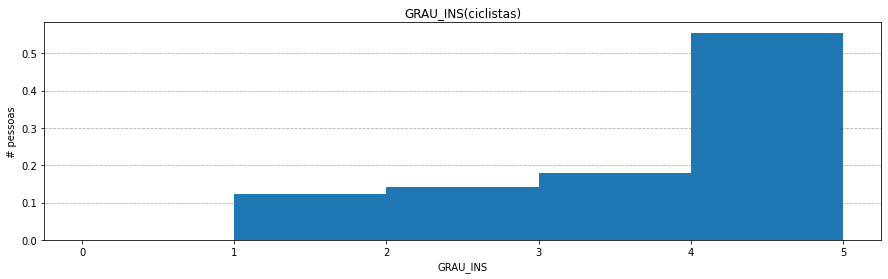

167760.362563
(0.5, 0.0)
(1.5, 0.12432710859317195)
(2.5, 0.14204109979227905)
(3.5, 0.1784662301010265)
(4.5, 0.40471486380165)
(5.5, 0.15045069771187214)
(6.5, 0.0)
16829270.88803827
(0.5, 0.0)
(1.5, 0.19069968936361492)
(2.5, 0.14464284089551385)
(3.5, 0.14710875788562497)
(4.5, 0.3508944190376835)
(5.5, 0.16665429281754898)
(6.5, 0.0)


In [19]:
compara_bike_geral('GRAU_INS', bins = range(6))

print_values(od_ciclistas, 'GRAU_INS', 1)
print_values(od_people, 'GRAU_INS', 1)

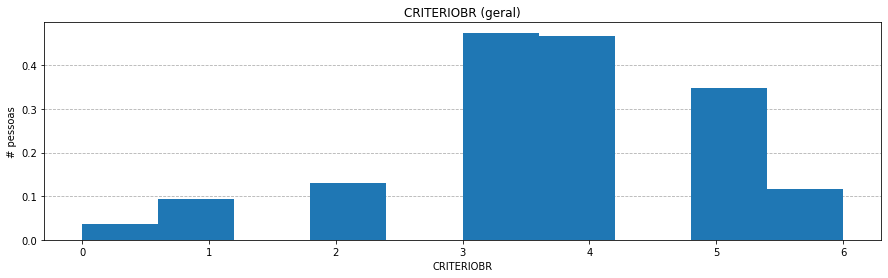

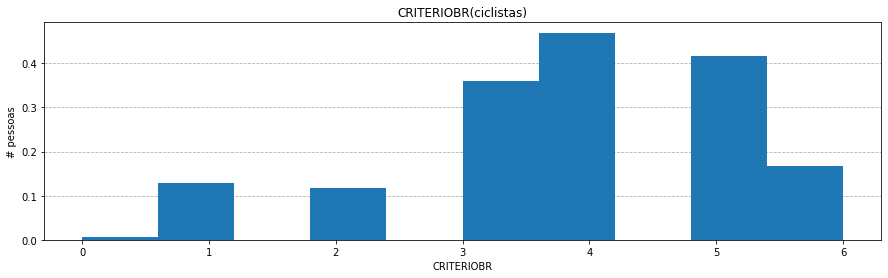

In [63]:
compara_bike_geral('CRITERIOBR')

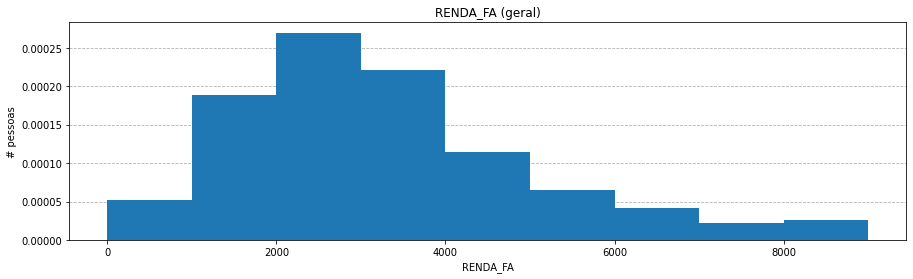

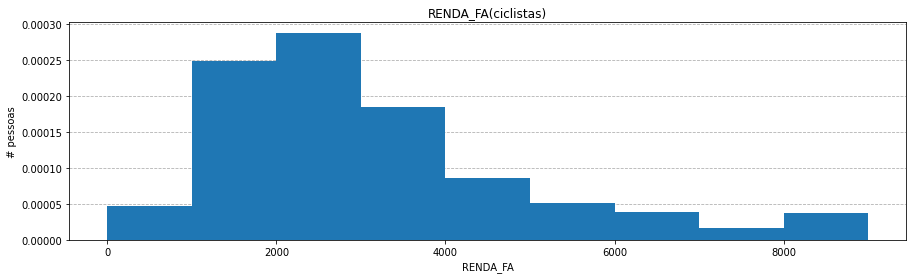

167760.362563
(500.0, 0.04460778714155264)
(1500.0, 0.2322879857175192)
(2500.0, 0.2687626660801234)
(3500.0, 0.17226253777406716)
(4500.0, 0.0804336258866434)
(5500.0, 0.047822943908977046)
(6500.0, 0.03628533565975112)
(7500.0, 0.015486903344193267)
(8500.0, 0.03039154124434687)
(9500.0, 0.017752676386125366)
(10500.0, 0.010171499923643737)
(11500.0, 0.006432448318027185)
(12500.0, 0.0038042578130476536)
(13500.0, 0.005154868872408662)
(14500.0, 0.00409131182428297)
(15500.0, 0.009954736109805745)
(16500.0, 0.002852387975856332)
(17500.0, 0.0003494556050329487)
(18500.0, 0.0012648149047741635)
(19500.0, 0.0019977577651821136)
(20500.0, 0.001136075370178264)
(21500.0, 0.0002894828924905463)
(22500.0, 0.0015406883726955267)
(23500.0, 0.000828340484468222)
(24500.0, 0.0)
(25500.0, 0.00088204263950867)
(26500.0, 0.0009374637584068155)
(27500.0, 0.0)
(28500.0, 0.0)
(29500.0, 0.0008360444020102138)
(30500.0, 0.0)
(31500.0, 0.0)
(32500.0, 0.0003980244378342021)
(33500.0, 0.0)
(34500.0, 0.00

In [17]:
compara_bike_geral('RENDA_FA', bins = range(0,10000,1000))

print_values(od_ciclistas, 'RENDA_FA', 1000)
print_values(od_people, 'RENDA_FA', 1000)

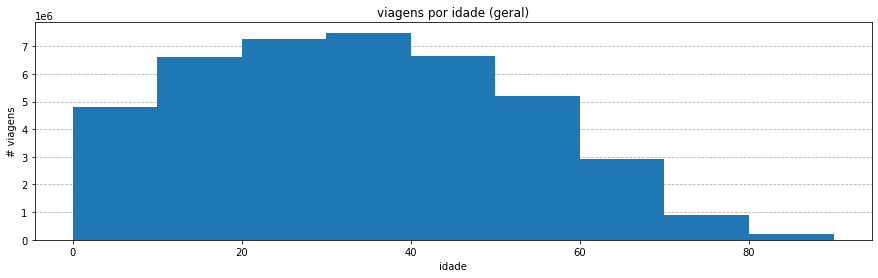

In [45]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=range(0,100,10), x=od_trips['IDADE'], weights = od_trips['FE_VIA'], density = False)
plt.title('viagens por idade (geral)')
plt.xlabel('idade')
plt.ylabel('# viagens')
plt.show()

In [ ]:
plt.figure(figsize=(15,4))
ax_distance = plt.axes()
ax_distance.set_axisbelow(True)
plt.grid(linestyle='--')
ax_distance.xaxis.grid(False)
plt.hist(bins=range(0,100,10), x=od_trips['IDADE'], weights = od_trips['FE_VIA'], density = False)
plt.title('viagens por idade (geral)')
plt.xlabel('idade')
plt.ylabel('# viagens')
plt.show()

In [36]:
pessoas_idade = []
ciclistas_idade = []
viagens_idade = []
viagens_bike_idade = []
for i in range(0, 65, 5):
    pessoas_idade.append(sum(od_people.loc[od_people['IDADE'] >= i].loc[od_people['IDADE'] < i + 5]['FE_PESS']))
    ciclistas_idade.append(sum(od_ciclistas.loc[od_ciclistas['IDADE'] >= i].loc[od_ciclistas['IDADE'] < i + 5]['FE_PESS']))
    
    viagens_idade.append(sum(od_trips.loc[od_trips['IDADE'] >= i].loc[od_trips['IDADE'] < i + 5]['FE_PESS']))
    viagens_bike_idade.append(sum(od_trips.loc[od_trips['MODOPRIN'] == 15].loc[od_trips['IDADE'] >= i].loc[od_trips['IDADE'] < i + 5]['FE_PESS']))


In [24]:
print(pessoas_idade)

[1464915.3792330043, 1251101.758096004, 1455250.8303989994, 1537909.6371789824, 1751222.5728079833, 1622158.1473259886, 1494982.3963079907, 1603144.5666089903, 1533920.9102829928, 1418723.508178994, 1420350.3917369915, 1254545.5320979974, 1200866.3373309951, 685028.5863180021, 476385.3774600012, 286908.3819920003, 203312.5602810007, 105117.53335599996, 43642.855364]


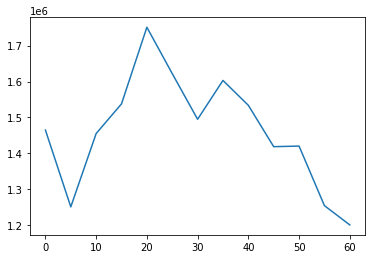

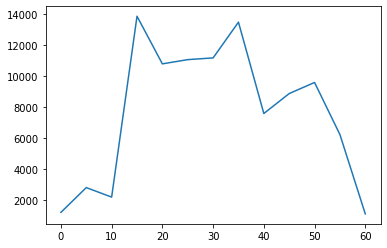

In [37]:
plt.plot(range(0, 65, 5), pessoas_idade)
plt.show()
plt.plot(range(0, 65, 5), ciclistas_idade)

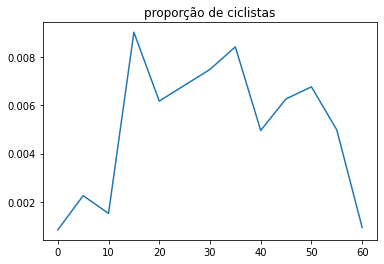

In [38]:
plt.title('proporção de ciclistas')
plt.plot(range(0, 65, 5), 
         [0 if pessoas_idade[i] == 0 else 
          ciclistas_idade[i] / pessoas_idade[i] for i in range(len(pessoas_idade))])

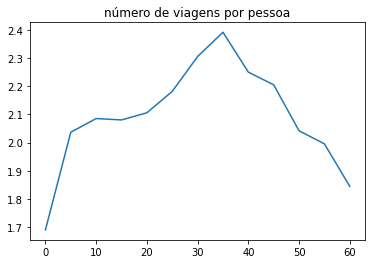

In [39]:
plt.title('número de viagens por pessoa')
plt.plot(range(0, 65, 5), 
         [0 if pessoas_idade[i] == 0 else 
          viagens_idade[i] / pessoas_idade[i] for i in range(len(pessoas_idade))])

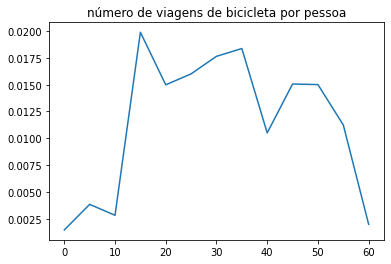

In [41]:
plt.title('número de viagens de bicicleta por pessoa')
plt.plot(range(0, 65, 5), 
         [0 if pessoas_idade[i] == 0 else 
          viagens_bike_idade[i] / pessoas_idade[i] for i in range(len(pessoas_idade))])